# Quantum Pulsar

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
from generate_toy_pulsar_data import generate_fake_data
print("Imports Successful")

Imports Successful


In [41]:
nchan, ntime = 64, 64
period_real = 6.4
dm_real = 25.
noise_frac = 0.0

data = generate_fake_data(nchan, ntime, period_real, dm_real, noise_frac)

(64, 64)


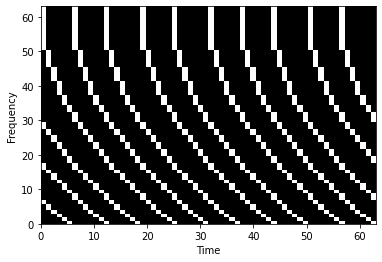

In [42]:
fig, ax = plt.subplots()
ax.imshow(data, vmin=0, vmax=1, origin='lower', aspect='auto',
          cmap='gray', extent=[0, ntime-1, 0, nchan-1])
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
fig.savefig("raw-data.svg")
print(data.shape)

[0, 3, 4, 8, 16, 32, 0, 0, 3, 4, 8, 16, 32, 0, 3, 4, 8, 16, 32, 0, 0, 3, 4, 8, 16, 32, 0, 3, 4, 8, 16, 32, 0, 3, 4, 8, 16, 32, 0, 0, 3, 4, 8, 16, 32, 0, 3, 4, 8, 16, 32, 0, 0, 3, 4, 8, 16, 32, 0, 3, 4, 8, 16, 32]


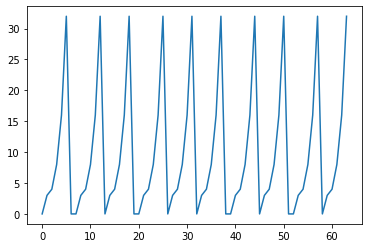

In [52]:
from utils import BitsToIntAFast

bits = []

n_count = 6
incr = 1
shift = 0

for icol in range(ntime):
    row_idx_start = shift
    row_idx_end = shift+n_count*incr
    d = data[row_idx_start:row_idx_end:incr,icol]
    bits.append(BitsToIntAFast(d, invert_bits_order=True))
plt.plot(bits)
print(bits)

In [53]:
# from qiskit.quantum_info.operators import Operator
from utils import tobin 

def BooleanBitsOracle(bit, nbit):
    
    npts = data.shape[0]
    nqbits_register1 = int(np.log2(npts))
    
    nqbits_register2 = nbit
    size = 2**(nqbits_register1+nqbits_register2)
    
    M = np.eye(size,size)
    
    
    for x in range(npts):
        
        xbin = tobin(x, nqbits_register1)
        y = int(bit[x])
        ybin = tobin(y, nqbits_register2)

        if ybin !=0:
            
            idx = int(ybin+xbin, 2)
            M[int(x), int(x)] = 0
            M[idx, idx] = 0
            M[int(x),idx] = 1
            M[idx,int(x)] = 1
    
    op = Operator(M)
    op.name = 'test'
    return op
    
oracle = BooleanBitsOracle(bits, nbits)

(4096, 4096)


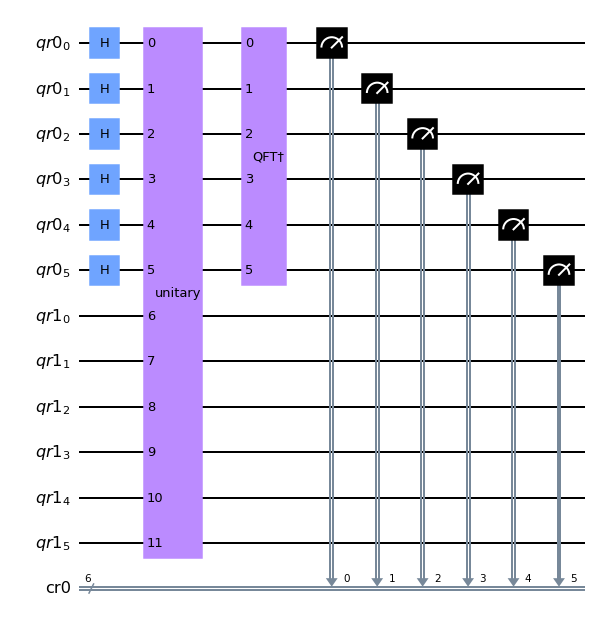

In [54]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
from utils import qft_dagger
nqubit_register1 = 6
nqubit_register2 = nbits

qc = QuantumCircuit(QuantumRegister(nqubit_register1, 'qr0'), 
                    QuantumRegister(nqubit_register2,'qr1'),
                    ClassicalRegister(nqubit_register1,'cr0'))


# Initialize counting qubits
# in state |+>
for q in range(nqubit_register1):
    qc.h(q)

# introduce the oracle
qc.append(oracle,list(range(0,nqubit_register1+nqubit_register2)))

# inv QFT
qc.append(qft_dagger(nqubit_register1), range(nqubit_register1))

# Measure circuit
qc.measure(range(nqubit_register1),range(nqubit_register1))
qc.draw('mpl')  # -1 means 'do not fold' 

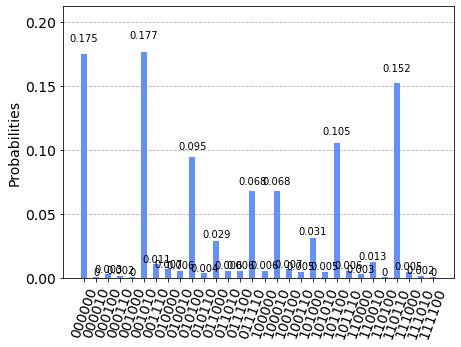

In [55]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [58]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**nbits)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**nbits} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

           Register Output         Phase
0   001000(bin) =   8(dec)   8/64 = 0.12
1   110100(bin) =  52(dec)  52/64 = 0.81
2   000100(bin) =   4(dec)   4/64 = 0.06
3   101010(bin) =  42(dec)  42/64 = 0.66
4   111100(bin) =  60(dec)  60/64 = 0.94
5   110010(bin) =  50(dec)  50/64 = 0.78
6   001110(bin) =  14(dec)  14/64 = 0.22
7   000010(bin) =   2(dec)   2/64 = 0.03
8   100100(bin) =  36(dec)  36/64 = 0.56
9   110110(bin) =  54(dec)  54/64 = 0.84
10  101110(bin) =  46(dec)  46/64 = 0.72
11  011000(bin) =  24(dec)  24/64 = 0.38
12  000000(bin) =   0(dec)   0/64 = 0.00
13  010000(bin) =  16(dec)  16/64 = 0.25
14  011110(bin) =  30(dec)  30/64 = 0.47
15  011100(bin) =  28(dec)  28/64 = 0.44
16  100000(bin) =  32(dec)  32/64 = 0.50
17  010100(bin) =  20(dec)  20/64 = 0.31
18  010010(bin) =  18(dec)  18/64 = 0.28
19  010110(bin) =  22(dec)  22/64 = 0.34
20  100010(bin) =  34(dec)  34/64 = 0.53
21  101000(bin) =  40(dec)  40/64 = 0.62
22  111010(bin) =  58(dec)  58/64 = 0.91
23  000110(bin) 

In [59]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(12)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

      Phase Fraction  Guess for r
0   0.12500      1/8            8
1   0.81250     9/11           11
2   0.06250     1/12           12
3   0.65625      2/3            3
4   0.93750    11/12           12
5   0.78125      7/9            9
6   0.21875      2/9            9
7   0.03125      0/1            1
8   0.56250      5/9            9
9   0.84375      5/6            6
10  0.71875      5/7            7
11  0.37500      3/8            8
12  0.00000      0/1            1
13  0.25000      1/4            4
14  0.46875     5/11           11
15  0.43750      4/9            9
16  0.50000      1/2            2
17  0.31250     3/10           10
18  0.28125      2/7            7
19  0.34375      1/3            3
20  0.53125     6/11           11
21  0.62500      5/8            8
22  0.90625    10/11           11
23  0.09375     1/11           11
24  0.87500      7/8            8
25  0.15625      1/6            6
26  0.68750     7/10           10
27  0.75000      3/4            4
28  0.40625   